In [1]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels
import pymc3 as pm
import bambi as bmb
import matplotlib.pyplot as plt
%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/home/xian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#data = pd.read_csv('./shooter.csv', sep=',', na_values='.')
df = pd.read_csv('./shooter-data/shooter-group.csv', sep=',')
df.head()

,subject,age,stimulus,trial,race,gun,rt,correct,rate
0,34,19,w94,19,0,1,451,1,2.217295
1,34,19,b12,20,1,1,492,1,2.032520
2,34,19,w90,21,0,0,636,1,1.572327
3,34,19,w97,22,0,0,636,1,1.572327
4,34,19,b16,23,1,1,529,1,1.890359


In [3]:
gun_absent = df[ df['gun'] == 0 ].groupby('subject').mean()
gun_present = df[ df['gun'] == 1 ].groupby('subject').mean()
w_target = df[ df['race'] == 0 ].groupby('subject').mean()
b_target = df[ df['race'] == 1 ].groupby('subject').mean()

In [4]:
gun_absent.head()

,age,trial,race,gun,rt,correct,rate
subject,,,,,,,
1,35.0,66.591837,0.510204,0.0,665.571429,1.000000,1.528727
2,35.0,65.877551,0.489796,0.0,647.224490,1.000000,1.562691
3,34.0,69.061224,0.489796,0.0,624.081633,1.000000,1.618863
4,34.0,68.340000,0.500000,0.0,611.880000,1.000000,1.669828
5,33.0,69.000000,0.520833,0.0,622.708333,0.958333,1.640014


In [5]:
gun_present.drop(columns=['trial', 'race'], inplace=True)
gun_absent.drop(columns=['trial', 'race'], inplace=True)
w_target.drop(columns=['trial', 'gun'], inplace=True)
b_target.drop(columns=['trial', 'gun'], inplace=True)

In [6]:
gun_absent.head()

,age,gun,rt,correct,rate
subject,,,,,
1,35.0,0.0,665.571429,1.000000,1.528727
2,35.0,0.0,647.224490,1.000000,1.562691
3,34.0,0.0,624.081633,1.000000,1.618863
4,34.0,0.0,611.880000,1.000000,1.669828
5,33.0,0.0,622.708333,0.958333,1.640014


## scipy

In [8]:
t,p = scipy.stats.ttest_rel(gun_present['rt'], gun_absent['rt'])
print(t, p)

-15.907174725726094 1.3618862888819598e-17


In [10]:
# investigate the relationship between age and average reaction time
sub_means = df.groupby('subject').mean()
r,p = scipy.stats.pearsonr(sub_means['age'], sub_means['rt'])
print(r, p)

0.2526573392414475 0.13709806660420984


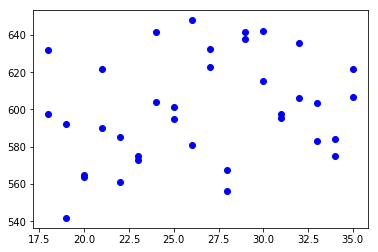

In [11]:
plt.plot(sub_means['age'], sub_means['rt'], 'bo')

In [12]:
r,p = scipy.stats.spearmanr(sub_means['age'], sub_means['rt'])
print(r, p)

0.26697608467831285 0.11547651011180153


## statsmodels

**Fully between-subject**

In [13]:
btw_aov_result = smf.ols('rt ~ race * gun', df).fit()
btw_aov_table = sm.stats.anova_lm(btw_aov_result, typ=2)
print(btw_aov_table)

                sum_sq      df           F        PR(>F)
race      6.154852e+03     1.0    0.800156  3.711083e-01
gun       3.259762e+06     1.0  423.782278  5.628394e-89
race:gun  2.788578e+05     1.0   36.252654  1.912428e-09
Residual  2.690685e+07  3498.0         NaN           NaN


**Within-subject, ANOVA-style**

In [17]:
wi_aov_model = statsmodels.stats.anova.AnovaRM(df, 'rt', 'subject', ['race', 'gun'], aggregate_func='mean')
wi_aov_result = wi_aov_model.fit()
print(wi_aov_result.summary())

                 Anova
         F Value  Num DF  Den DF Pr > F
---------------------------------------
race       1.0994 1.0000 35.0000 0.3016
gun      251.0629 1.0000 35.0000 0.0000
race:gun  60.1064 1.0000 35.0000 0.0000



In [18]:
# per-cell data
nogun_black = df[ (df['gun'] == 0) & (df['race'] == 0)].groupby('subject').mean()
nogun_white = df[ (df['gun'] == 0) & (df['race'] == 1)].groupby('subject').mean()
gun_white = df[ (df['gun'] == 1) & (df['race'] == 0)].groupby('subject').mean()
gun_black = df[ (df['gun'] == 1) & (df['race'] == 1)].groupby('subject').mean()

In [19]:
# example pair-wise comparison
t,p = scipy.stats.ttest_rel(nogun_black['rt'], gun_white['rt'])
print(t, p)

10.791593824133901 1.1128969055398514e-12


**Within subjects, Mixed model-style**

In [20]:
model = smf.mixedlm('rt ~ race * gun', data=df, groups=df['subject'])
result = model.fit()
print(result.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: rt         
No. Observations: 3502    Method:             REML       
No. Groups:       36      Scale:              6987.9281  
Min. group size:  94      Likelihood:         -20501.1152
Max. group size:  100     Converged:          Yes        
Mean group size:  97.3                                   
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept  620.474    5.304 116.978 0.000 610.078 630.870
race        20.471    4.019   5.094 0.000  12.594  28.348
gun        -43.113    3.998 -10.783 0.000 -50.950 -35.277
race:gun   -35.829    5.651  -6.340 0.000 -46.905 -24.752
Group Var  723.610    2.286                              



## pymc3

In [25]:
# create a copy of the data for these analyses
pmdf = df.copy(deep=True)

# recode relevant variables so that they run 0..., in order
id = pmdf.subject.unique()
id_lookup = dict(zip(id, range(len(id))))
subject = pmdf['subject'] = pmdf.subject.replace(id_lookup).values

gun = pmdf.gun.unique()
gun_lookup = dict(zip(gun, range(len(gun))))
gun = pmdf['gun'] = pmdf.gun.replace(gun_lookup).values

race_cond = pmdf.race.unique()
race_lookup = dict(zip(race_cond, range(len(race_cond))))
race = pmdf['race'] = pmdf.race.replace(race_lookup).values

In [26]:
# do a 'repeated measures ANOVA', treating subject as a random effect (intercepts and slopes)
with pm.Model() as my_model:
    mean = 0
    sd = 1e5
    b = 5

    # intercepts
    alpha = pm.Normal('alpha', mean, sd=sd)
    alpha_beta = pm.HalfCauchy('alpha_beta', b)
    alpha_s = pm.Normal('alpha_s', alpha, sd=alpha_beta, shape=len(np.unique(df.subject.values)))

    # coefficients for gun
    beta_gun = pm.Normal('beta_gun', mean, sd=sd)
    beta_gun_beta = pm.HalfCauchy('beta_gun_beta', b)
    beta_gun_s = pm.Normal('beta_gun_s', beta_gun, sd=beta_gun_beta, shape=len(np.unique(df.subject.values)))

    # coefficient for race
    beta_race = pm.Normal('beta_race', mean, sd=sd)
    beta_race_beta = pm.HalfCauchy('beta_race_beta', b)
    beta_race_s = pm.Normal('beta_race_s', beta_race, sd=beta_race_beta, shape=len(np.unique(df.subject.values)))

    # coefficient for interaction
    beta_gunrace = pm.Normal('beta_gunrace', mean, sd=sd)
    beta_gunrace_beta = pm.HalfCauchy('beta_gunrace_beta', b)
    beta_gunrace_s = pm.Normal('beta_gunrace_s', beta_gunrace, sd=beta_gunrace_beta, shape=len(np.unique(df.subject.values)))

    # Expected value
    y_hat = alpha_s[subject] + (beta_gun_s[subject] * gun) + (beta_race_s[subject] * race) + (beta_gunrace_s[subject] * gun * race)

    # Model error
    sigma_y = pm.HalfCauchy('sigma_y', b)

    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sd=sigma_y, observed=pmdf.rt.values)

In [27]:
with my_model:
    pm.init_nuts(n_init=500)

Initializing NUTS using jitter+adapt_diag...
/home/xian/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):


In [28]:
with my_model:
    my_model = pm.sample(1000, n_init=50000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/xian/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_y_log__, beta_gunrace_s, beta_gunrace_beta_log__, beta_gunrace, beta_race_s, beta_race_beta_log__, beta_race, beta_gun_s, beta_gun_beta_log__, beta_gun, alpha_s, alpha_beta_log__, alpha]
 12%|█▏        | 242/2000 [00:08<01:04, 27.33it/s] /home/xian/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 2000/2000 [04:37<00:00,  7.22it/s]
There were 49 divergences after tuning. Increase `target_accept` or reparameteri

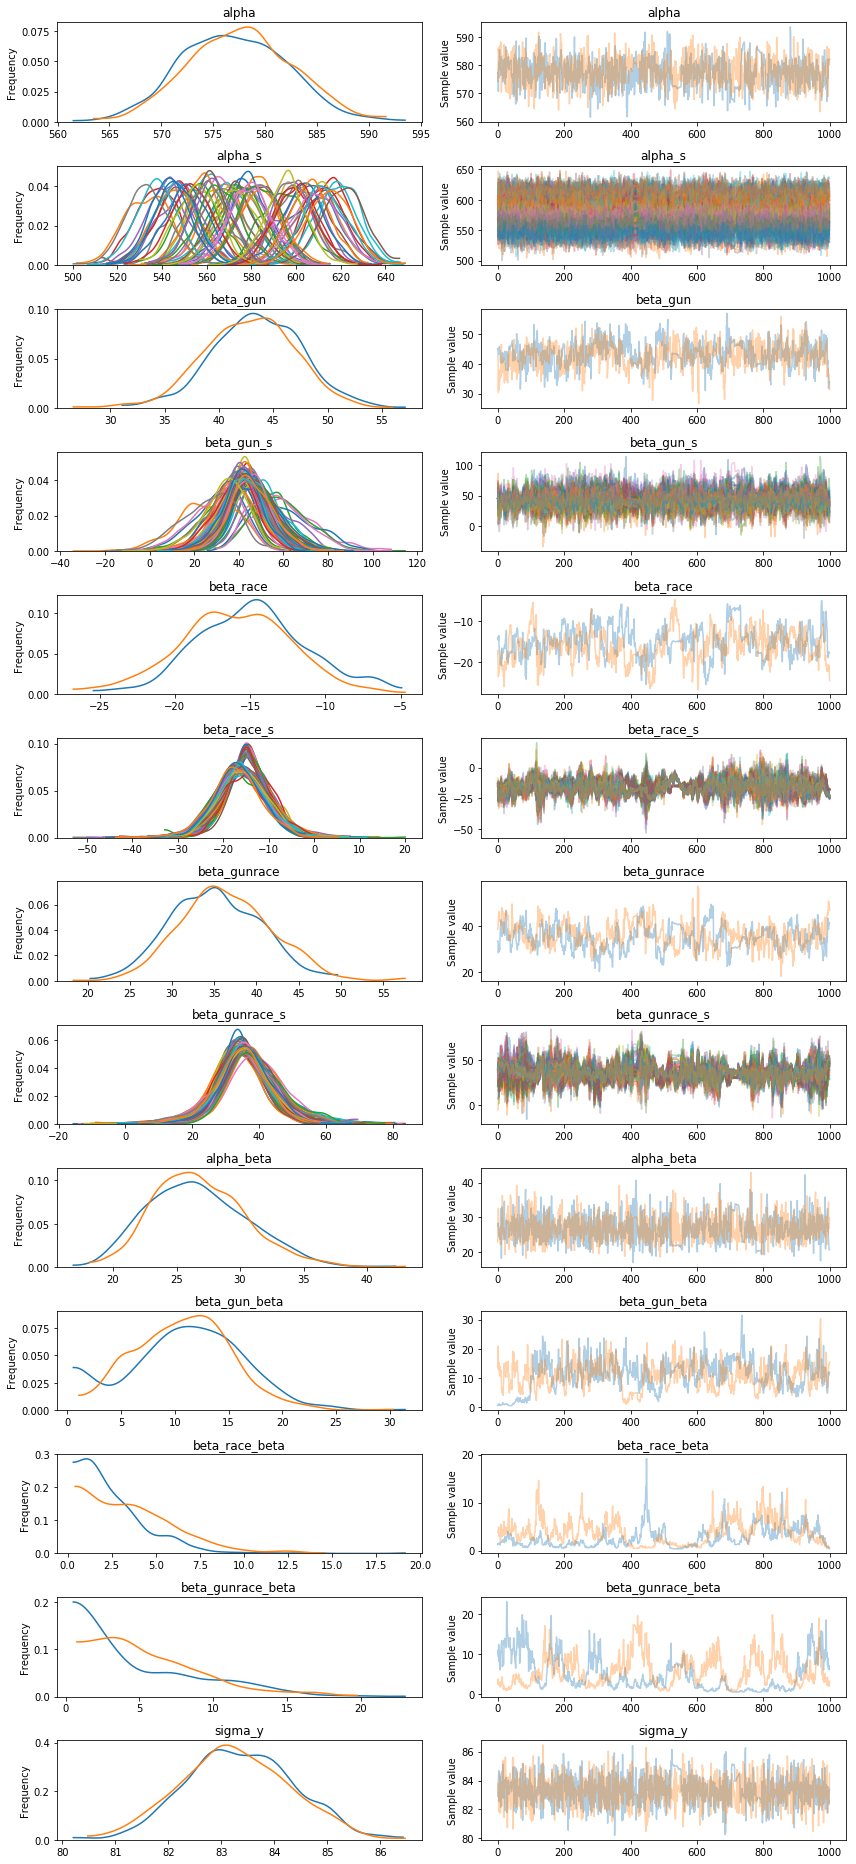

In [36]:
pm.plots.traceplot(my_model);

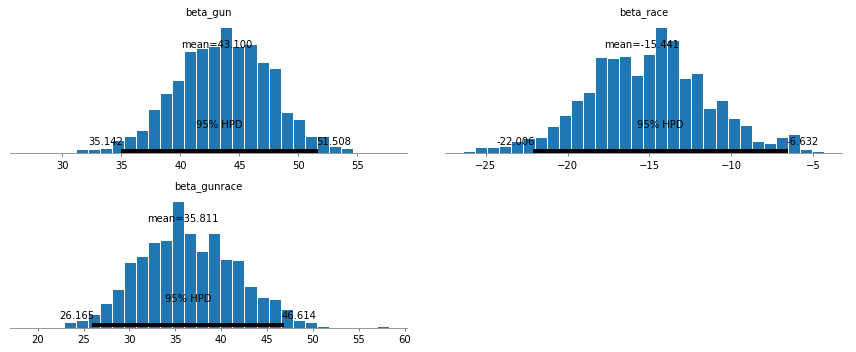

In [37]:
pm.plot_posterior(my_model, varnames=['beta_gun','beta_race','beta_gunrace']);

In [33]:
(my_model['beta_race'] < 0).mean()

1.0

## bambi

In [38]:
# do an 'ANOVA' with subject as random effect
subj_model  = bmb.Model(df)

subj_fitted = subj_model.fit('rt ~ race * gun',
                             random=['race * gun | subject'],
                             samples=500, chains=1, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 22,984:   9%|▉         | 4433/50000 [00:09<01:42, 444.02it/s]/home/xian/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
Average Loss = 20,605: 100%|██████████| 50000/50000 [01:54<00:00, 437.55it/s]
Finished [100%]: Average Loss = 20,604
/home/xian/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Sequential sampling (2 chains in 1 job)
NUTS: [rt_sd_interval__, race:gun| subject_offset, race:gun| subject_sd_log__, gun| subject_offset, gun| subject_sd_log__, race| subject_offset, race| subject_sd_log__, 1| subject_offset, 1| subject_sd_log_

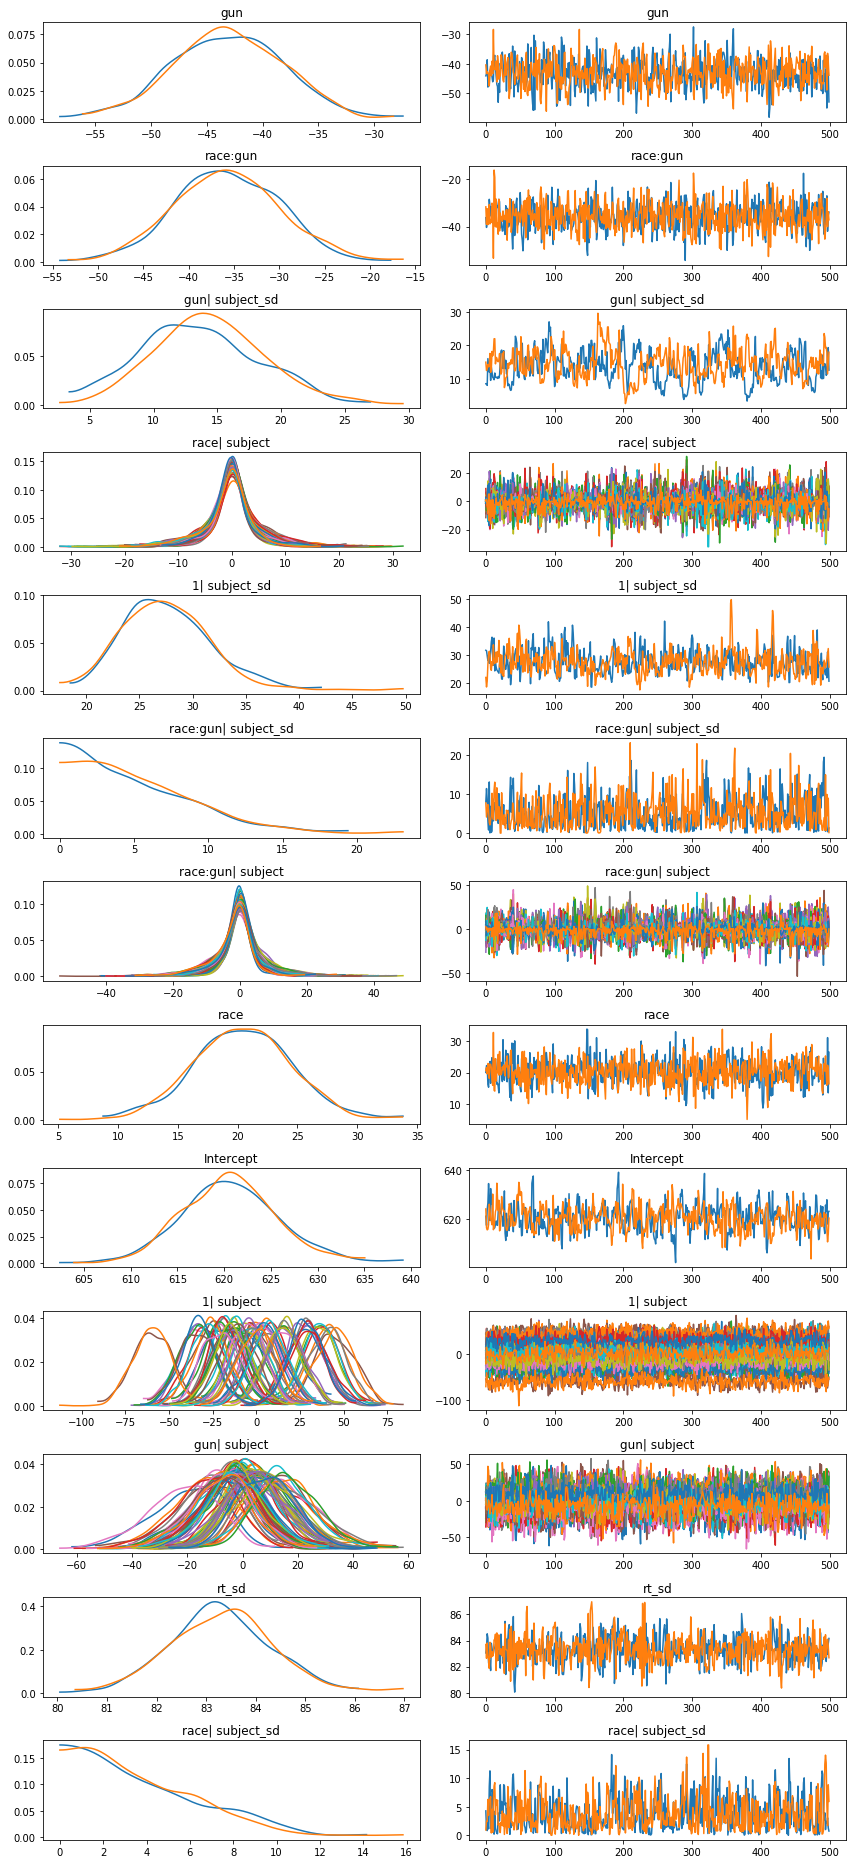

In [39]:
# inspect posteriors & traces
_ = subj_fitted.plot()

In [40]:
subj_fitted.summary()

,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
1| subject_sd,27.569506,4.224247,20.121152,36.054522,376,0.999556
Intercept,620.582712,5.087759,610.954650,631.072590,374,0.999450
gun,-43.070078,4.908156,-52.322118,-33.203879,749,0.999066
gun| subject_sd,14.024855,4.453679,5.281132,22.283543,102,1.010275
race,20.404798,4.075183,12.425850,28.313044,1000,0.999623
race:gun,-35.719565,5.780807,-46.831559,-24.434964,973,0.999049
race:gun| subject_sd,5.287349,4.088771,0.004029,13.027720,547,1.000241
race| subject_sd,3.811418,2.922306,0.002453,9.241361,503,0.999182
rt_sd,83.312695,1.036901,81.281976,85.289362,1000,0.999731


- The group-level interaction term (race:gun) has a posterior that is far from zero, suggesting that the interaciton we visualized previously (subjects being relatively faster/slower to shoot armed/unarmed black individual) is probable.

In [41]:
(subj_fitted['race:gun'].to_df() < 0).mean()

race:gun    1.0
dtype: float64

- The posterior probability that the interaction coefficient is less than zero is 0.99.

## Mixed model

In [7]:
substim_fitted = subj_model.fit('rt ~ race * gun',
                             random=['race * gun | subject', 'gun|target'],
                             samples=500, chains=1, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 29,880:   7%|▋         | 3547/50000 [00:09<02:10, 354.73it/s]/home/xian/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
Average Loss = 22,707: 100%|██████████| 50000/50000 [02:18<00:00, 361.68it/s]
Finished [100%]: Average Loss = 22,707
/home/xian/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Sequential sampling (2 chains in 1 job)
NUTS: [rt_sd_interval__, gun[T.nogun]|target_offset, gun[T.nogun]|target_sd_log__, 1|target_offset, 1|target_sd_log__, race[T.white]:gun[T.nogun]| subject_offset, race[T.white]:gun[T.nogun]| subject_sd_log_

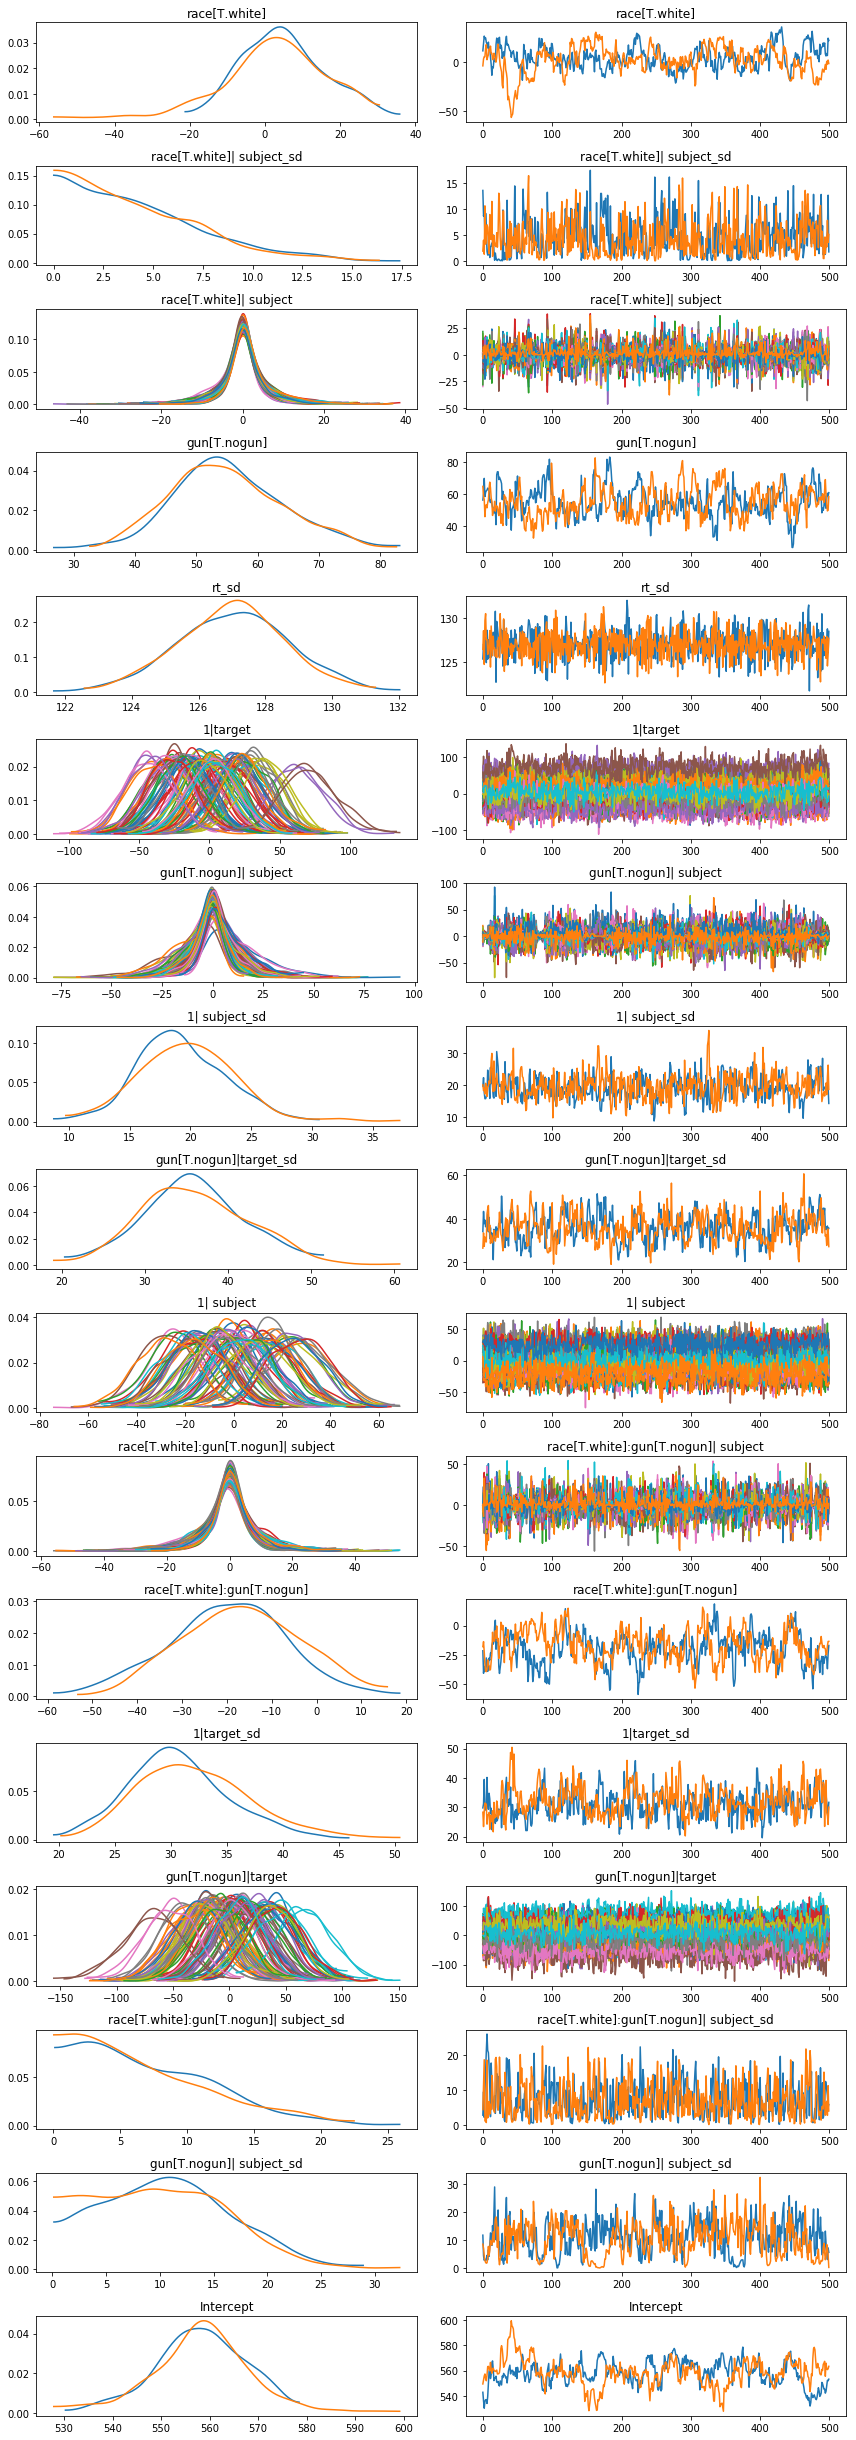

In [8]:
# inspect posteriors & traces
_ = substim_fitted.plot()

In [9]:
substim_fitted.summary()

,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
1| subject_sd,19.461207,3.770264,11.809740,26.240480,414,1.005940
1|target_sd,31.461739,4.850907,22.036958,40.614883,166,1.023344
Intercept,558.220789,9.860395,535.585023,575.258889,43,0.999392
gun[T.nogun],55.094067,9.168955,39.697488,75.279274,133,0.999261
gun[T.nogun]| subject_sd,10.465375,5.944555,0.131285,20.615031,110,1.002569
gun[T.nogun]|target_sd,35.905716,6.313215,24.095634,47.935949,214,0.999079
race[T.white],3.558276,12.766369,-19.602013,27.674101,31,1.014031
race[T.white]:gun[T.nogun],-18.396255,13.186456,-44.320169,7.076250,90,1.015544
race[T.white]:gun[T.nogun]| subject_sd,7.005265,5.044005,0.049202,16.804521,400,1.000830
race[T.white]| subject_sd,4.420392,3.446070,0.015123,11.379386,354,0.999599


- Now the interaction isn't so clear.  A non-trivial portion of the posterior lies above zero. 

In [14]:
(substim_fitted['race:gun'].to_df() < 0).mean()

race[T.white]:gun[T.nogun]    0.913
dtype: float64

- The posterior probability of the interaction being less than zero is only 0.913.

## TBD: Machline learning w/ scikit-learn